# 02. Neural network classification with pytorch

## 1. Make classification data and get it ready

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [4]:
len(x), len(y)

(1000, 1000)

In [5]:
print(f"x: {x[:5]}")
print(f"y: {y[:5]}")

x: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
y: [1 1 1 1 0]


In [6]:
import pandas as pd
circles = pd.DataFrame({"X1" : x[:, 0],
                       "X2" : x[:, 1],
                       "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


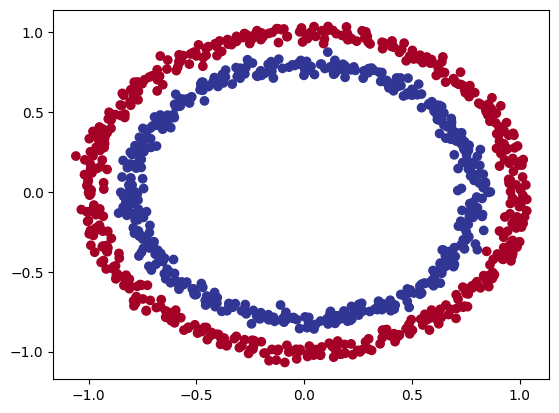

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=x[:, 0],
           y=x[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu)

### 1.1 check input and output shapes

In [8]:
x.shape, y.shape

((1000, 2), (1000,))

In [9]:
x

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
x_sample = x[0]
y_sample = y[0]

print(f"x_sample: {x_sample}")
print(f"y_sample: {y_sample}")
print(f"x_sample.shape: {x_sample.shape}")
print(f"y_sample.shape: {y_sample.shape}")

x_sample: [0.75424625 0.23148074]
y_sample: 1
x_sample.shape: (2,)
y_sample.shape: ()


### 1.2 turn data into tensors and create train and test splits

In [11]:
import torch
torch.__version__

'2.4.0+cu121'

In [12]:
type(x)

numpy.ndarray

In [13]:
y = torch.from_numpy(y).type(torch.float)
x =  torch.from_numpy(x).type(torch.float)
x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(x), x.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2)

In [16]:
len(x_train), len(y_train), len(x_test), len(y_test)

(800, 800, 200, 200)

In [17]:
n_samples

1000

## 2. Building a model

In [18]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
x_train

tensor([[-0.1495, -0.9860],
        [ 0.3730,  0.9310],
        [ 0.2985, -0.9833],
        ...,
        [ 0.2932,  0.9742],
        [-0.8440,  0.6172],
        [-0.6634, -0.6744]])

In [20]:
class CircleModelV0(nn.Module) :
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 features to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # output (same shape with y)


  def forward(self, x) :
    return self.layer_2(self.layer_1(x)) # x->layer1 -> layer2 ->output

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.1143, -0.3098],
        [ 0.0013, -0.4994],
        [ 0.6967, -0.0308],
        [-0.4124,  0.6317],
        [-0.6392, -0.3301]], device='cuda:0', requires_grad=True)

In [22]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6731, -0.1241],
                      [ 0.0842, -0.4111],
                      [-0.0728, -0.3999],
                      [-0.0903,  0.0712],
                      [-0.2443, -0.1199]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5489,  0.5798, -0.4977,  0.2938, -0.5580], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1856,  0.3835, -0.2139, -0.0275,  0.0173]], device='cuda:0')),
             ('1.bias', tensor([0.1102], device='cuda:0'))])

In [24]:
with torch.inference_mode() :
  untrained_preds = model_0(x_test.to(device))
print(F"length of predictions : {len(untrained_preds)}")
print(f"predictions : {torch.round(untrained_preds[:10])}")
print(f"actual values : {y_test[:10]}")

length of predictions : 200
predictions : tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
actual values : tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1.])


## 2.1 Setup loss function and optimizer

In [25]:
# loss_fn = nn.BCELoss()
#nn.Sequential(
#    nn.Sigmoid(),
#    nn.BCELoss()
#)
# ==
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [34]:
def accuracy_fn(y_true, y_pred) :
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

### 3.1 Going from raw logits -> prediction probablities -> prediction labels

In [27]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
model_0.eval()
with torch.inference_mode() :
  y_logits = model_0(x_test.to(device))
y_logits[:5]

tensor([[0.2462],
        [0.2636],
        [0.2460],
        [0.2690],
        [0.3159]], device='cuda:0')

In [29]:
y_test[:5]

tensor([1., 0., 1., 0., 0.])

In [30]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.5612],
        [0.5655],
        [0.5612],
        [0.5669],
        [0.5783]], device='cuda:0')

In [31]:
torch.round(y_pred_probs[:5])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [32]:
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

### 3.2 Building a training and testing loop

In [36]:
epochs = 100

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs) :
  model_0.train()

  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, # BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = accuracy_fn(y_true = y_test,
                            y_pred = test_pred)

  if epoch % 10 == 0 :
    print(f"Epoch : {epoch} | Loss : {loss:.5f} | Accuracy : {acc:.2f}% | Test Loss : {test_loss:.5f}")

Epoch : 0 | Loss : 0.70721 | Accuracy : 49.38% | Test Loss : 52.50000
Epoch : 10 | Loss : 0.69842 | Accuracy : 49.38% | Test Loss : 52.50000
Epoch : 20 | Loss : 0.69586 | Accuracy : 53.87% | Test Loss : 52.50000
Epoch : 30 | Loss : 0.69502 | Accuracy : 50.62% | Test Loss : 54.00000
Epoch : 40 | Loss : 0.69466 | Accuracy : 50.00% | Test Loss : 53.50000
Epoch : 50 | Loss : 0.69445 | Accuracy : 49.38% | Test Loss : 53.00000
Epoch : 60 | Loss : 0.69429 | Accuracy : 49.00% | Test Loss : 51.50000
Epoch : 70 | Loss : 0.69416 | Accuracy : 49.50% | Test Loss : 51.00000
Epoch : 80 | Loss : 0.69404 | Accuracy : 48.88% | Test Loss : 51.50000
Epoch : 90 | Loss : 0.69394 | Accuracy : 48.50% | Test Loss : 51.50000


## 4. Make predictions and evaluate the model

In [39]:
import requests

from pathlib import Path

if Path("helper_functions.py").is_file() :
  print("helper_functions.py already exists")
else :
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f :
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


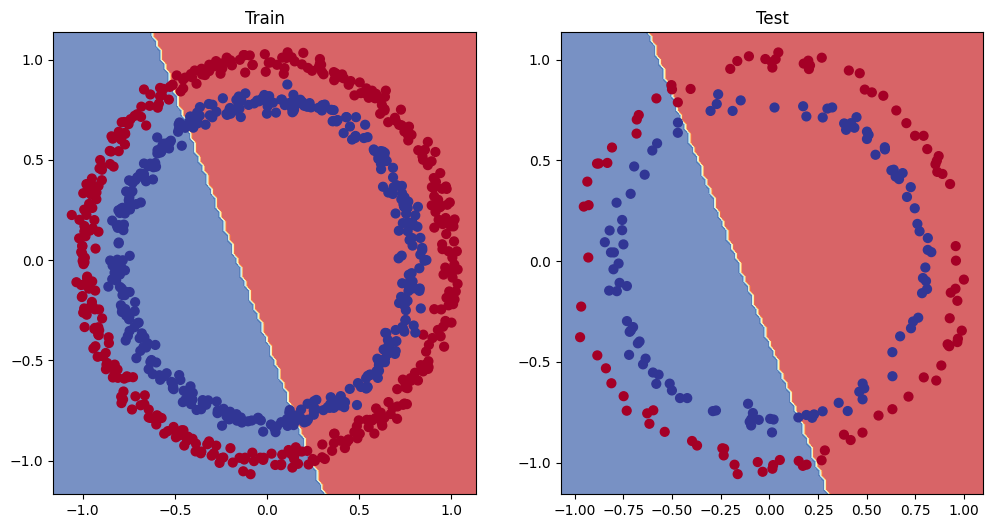

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,x_test,y_test)


## 5. Improving a model